In [1]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\iu2frl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from scipy.io import wavfile

In [19]:
# Replace with your file path
filename = 'SDRuno_20250710_182639Z_115766kHz.wav'

In [20]:
# Read the WAV file
sample_rate, data = wavfile.read(filename)

# If data is int16, convert to float32 in range [-1, 1]
if data.dtype == np.int16:
    data = data.astype(np.float32) / 32768.0
    
# Separate I and Q channels
I = data[:, 0]
Q = data[:, 1]

# Combine into complex IQ samples
iq_samples = I + 1j * Q

print(f"Sample rate: {sample_rate} Hz")
print(f"Number of samples: {len(iq_samples)}")

Sample rate: 2000000 Hz
Number of samples: 7557120


C:\Users\iu2frl\AppData\Local\Temp\ipykernel_11340\200110323.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


In [21]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt

# For angle calculations and signal processing
from numpy.fft import fft, ifft, fftshift
from scipy.signal import firwin, lfilter, hilbert

In [6]:
# Apply AM demodulation to get REF signal
def am_demodulate(iq_samples):
    # Calculate the magnitude (envelope) of the complex signal
    envelope = np.abs(iq_samples)
    
    # Design a lowpass filter with cutoff at 500 Hz
    nyquist = sample_rate / 2
    cutoff = 500 / nyquist
    b = firwin(101, cutoff)
    
    # Apply the filter to get the REF signal (30 Hz)
    ref_signal = lfilter(b, 1, envelope)
    
    return ref_signal

In [7]:
# Extract and demodulate the FM subcarrier to get VAR signal
def fm_demodulate(iq_samples):
    # Design bandpass filter to isolate FM signal at 9.96 kHz
    nyquist = sample_rate / 2
    low_cutoff = 9960 - 500  # Hz
    high_cutoff = 9960 + 500  # Hz
    
    # Normalize frequencies to Nyquist rate
    low_norm = low_cutoff / nyquist
    high_norm = high_cutoff / nyquist
    
    # Create bandpass filter
    b = firwin(201, [low_norm, high_norm], pass_zero=False)
    
    # Apply bandpass filter
    filtered_signal = lfilter(b, 1, iq_samples)
    
    # Shift the 9.96 kHz signal to baseband
    t = np.arange(len(filtered_signal)) / sample_rate
    shift_signal = filtered_signal * np.exp(-1j * 2 * np.pi * 9960 * t)
    
    # Apply lowpass filter to remove high-frequency components
    cutoff = 100 / nyquist  # Lowpass to keep only the 30 Hz modulation
    b_lp = firwin(101, cutoff)
    shift_signal_filtered = lfilter(b_lp, 1, shift_signal)
    
    # FM demodulation - differentiate the phase
    phase = np.unwrap(np.angle(shift_signal_filtered))
    var_signal = np.diff(phase) * (sample_rate / (2 * np.pi))
    
    # Pad to maintain original length
    var_signal = np.pad(var_signal, (0, 1), 'constant')
    
    # Final lowpass filter to isolate the 30 Hz signal
    cutoff_final = 50 / nyquist
    b_final = firwin(101, cutoff_final)
    var_signal = lfilter(b_final, 1, var_signal)
    
    return var_signal

In [8]:
# Calculate bearing from REF and VAR signals
def calculate_bearing(ref_signal, var_signal, duration=1.0):
    # Use a portion of the signal (default 1 second)
    samples = int(duration * sample_rate)
    start_idx = len(ref_signal) // 2  # Use middle section of the signal
    
    ref_segment = ref_signal[start_idx:start_idx+samples]
    var_segment = var_signal[start_idx:start_idx+samples]
    
    # Normalize signals
    ref_segment = (ref_segment - np.mean(ref_segment)) / np.std(ref_segment)
    var_segment = (var_segment - np.mean(var_segment)) / np.std(var_segment)
    
    # Find phase difference using cross-correlation
    correlation = np.correlate(ref_segment, var_segment, mode='full')
    max_idx = np.argmax(np.abs(correlation))
    
    # Calculate the shift
    shift = max_idx - (len(ref_segment) - 1)
    
    # Convert shift to phase difference in degrees
    # For 30 Hz signal with given sample rate
    samples_per_cycle = sample_rate / 30
    phase_diff = (shift / samples_per_cycle) * 360
    
    # Normalize to 0-360 degrees
    bearing = phase_diff % 360
    
    return bearing

In [22]:
ref_signal = am_demodulate(iq_samples)

In [23]:
var_signal = fm_demodulate(iq_samples)

In [24]:

# Calculate bearing
bearing = calculate_bearing(ref_signal, var_signal)
print(f"Calculated bearing: {bearing:.1f} degrees")

Calculated bearing: 278.7 degrees


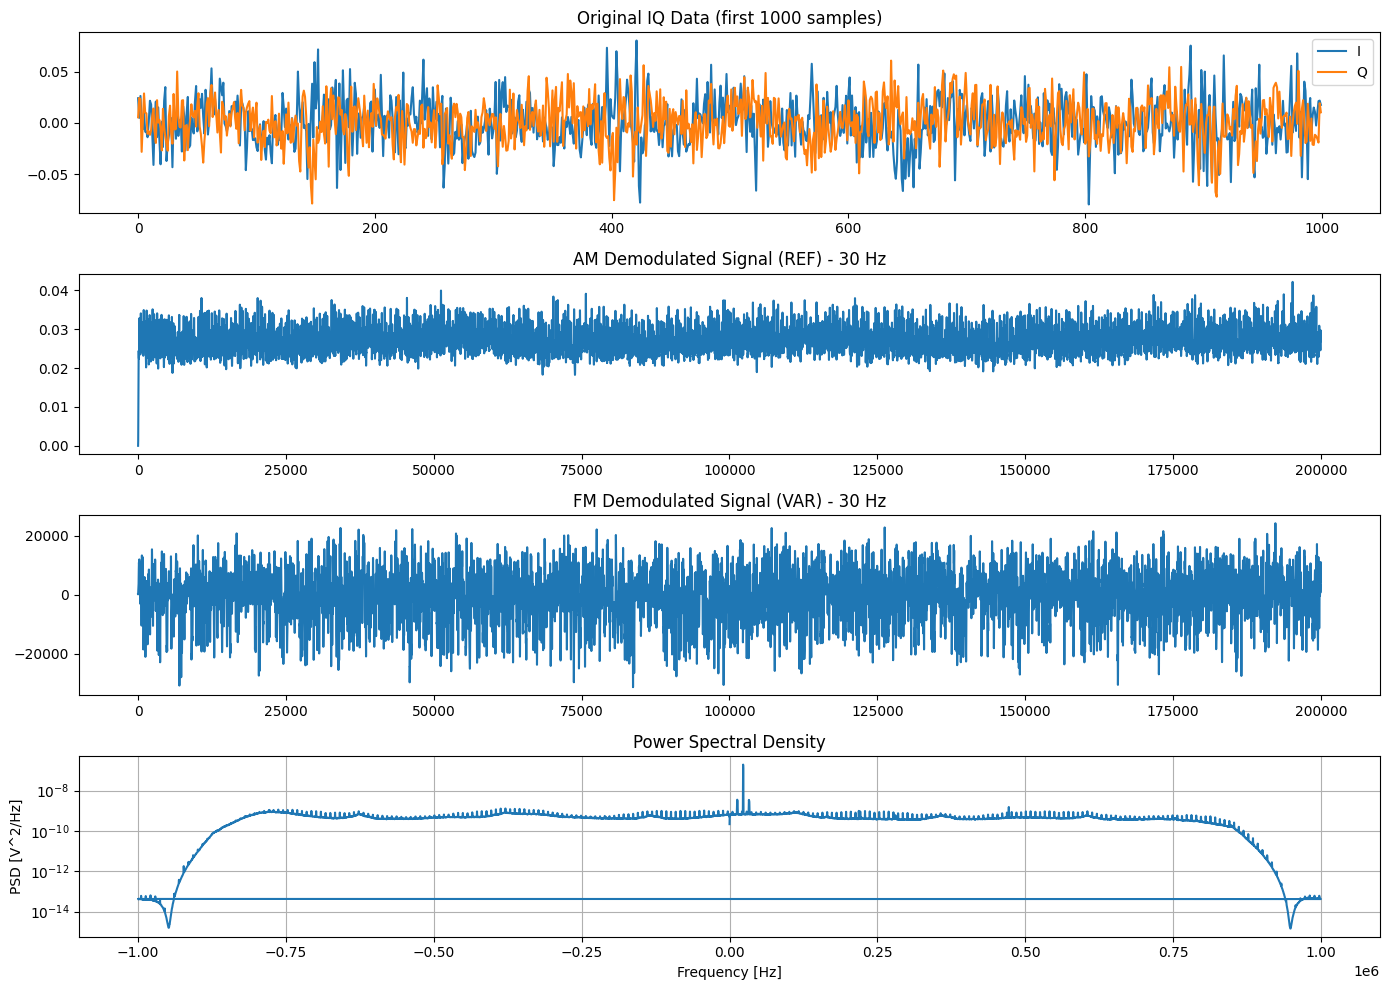

In [18]:
# Plot results
plt.figure(figsize=(14, 10))

# Plot original IQ data
plt.subplot(4, 1, 1)
plt.plot(np.real(iq_samples[:1000]))
plt.plot(np.imag(iq_samples[:1000]))
plt.title('Original IQ Data (first 1000 samples)')
plt.legend(['I', 'Q'])

# Plot AM demodulated signal (REF)
plt.subplot(4, 1, 2)
plt.plot(ref_signal[:sample_rate//10])  # Show 0.1 seconds
plt.title('AM Demodulated Signal (REF) - 30 Hz')

# Plot FM demodulated signal (VAR)
plt.subplot(4, 1, 3)
plt.plot(var_signal[:sample_rate//10])  # Show 0.1 seconds
plt.title('FM Demodulated Signal (VAR) - 30 Hz')

# Plot spectral view
plt.subplot(4, 1, 4)
f, Pxx = signal.welch(iq_samples, sample_rate, nperseg=8192)
plt.semilogy(f, Pxx)
plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.grid(True)

plt.tight_layout()
plt.show()